In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint

import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
%matplotlib inline

In [2]:
validation_split = 0.3
shuffle_dataset  = True
batch_size = 64
max_epochs = 100
input_size = 33

In [3]:
def load_transaction():
    df = pd.read_csv("transaction_dataset.csv")

    #Rename columns for easier access
    df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

    #Remove weird stuff 
    df.drop(columns=['unnamed:_0'], inplace=True)

    #Remove duplicate accounts
    df.drop_duplicates(subset=['address'], inplace=True)

    #Remove accounts 
    df.drop(columns=['address'], inplace=True)

    #Remove index
    df.drop(columns=['index'], inplace=True)

    #Remove token names 
    df.drop(columns=['erc20_most_sent_token_type','erc20_most_rec_token_type'], inplace = True)

    #Remove var=0 columns
    df.drop(df.var(numeric_only=True)[df.var(numeric_only=True) == 0].index, axis = 1, inplace = True)

    #Remove small distribution columns
    small_distr_col = []
    for col in df.columns[3:] :
        if df[col].nunique() < 10:
            small_distr_col.append(col)
    df.drop(columns=small_distr_col,inplace = True)
    
    # Remove negative values 
    df[df<0] = None 
    df.dropna(inplace=True)
    
    return df


def train_test_split_indices(length, validation_split, shuffle_dataset = True, random_seed = 42):
    # Creating data indices for training and validation splits.
    indices = np.arange(length)
    validation_size = int(validation_split * length)
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[validation_size:], indices[:validation_size]
    return train_indices, val_indices


In [4]:
class MyDataset(Dataset):
    def __init__(self, df, indices, augment = False, 
                 cols_median = None, cols_means = None, cols_std = None):
        super().__init__()
        self.augment = augment
        
        df = df.iloc[indices].copy()
        
        if(self.augment):
            oversample = SMOTE()
            df,y = oversample.fit_resample(df.iloc[:,1:],df.values[:,0])
        else: 
            y,df  = df.values[:, 0],df.iloc[:, 1:]
        
        if any(param is None for param in [cols_median, cols_means, cols_std]):
            self.cols_median = df.median(numeric_only=True)
            self.cols_means  = df.mean  (numeric_only=True)
            self.cols_std    = df.std   (numeric_only=True)
        else:
            self.cols_median = cols_median
            self.cols_means  = cols_means
            self.cols_std    = cols_std
            
        df.fillna(self.cols_median, inplace = True)
        df = (df - self.cols_means) / self.cols_std
        
        self.y = y
        self.X = df.values                                    
        
    def get_cols_stats(self):
        return self.cols_median, self.cols_means, self.cols_std
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment:
            pass
        
        return x, y

In [5]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, df, batch_size, train_indices, val_indices,augment):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.train_indices = train_indices
        self.val_indices = val_indices
        self.augment = augment

    def setup(self, stage = None):
        self.train_set = MyDataset(self.df, self.train_indices, augment = True)
        
        train_cols_median, train_cols_means, train_cols_std = self.train_set.get_cols_stats()
        
        self.val_set = MyDataset(self.df, self.val_indices,
                                 augment = False,
                                 cols_median = train_cols_median,
                                 cols_means  = train_cols_means,
                                 cols_std    = train_cols_std)
  
    def train_dataloader(self):
        return DataLoader(self.train_set,
                          batch_size = self.batch_size,
                          shuffle = True,
                          num_workers = 8,
                          pin_memory = True)

    def val_dataloader(self):
        return DataLoader(self.val_set,
                          batch_size = self.batch_size,
                          shuffle = False,
                          num_workers = 8,
                          pin_memory = True)

In [6]:
def train(model,file_name,path="./models",augment=True,validation_split=validation_split,
          shuffle_dataset=shuffle_dataset,batch_size=batch_size,
         max_epochs=max_epochs,input_size=input_size):

    df = load_transaction()


    train_indices, val_indices = train_test_split_indices(length = len(df),
                                                      validation_split = validation_split)        

    data = MyDataModule(df,
                        train_indices = train_indices,
                        val_indices   = val_indices,
                        batch_size    = batch_size,
                        augment       = augment)
    early_stopping = EarlyStopping('val_loss',patience=7)
    
    checkpoint_callback = ModelCheckpoint(
                            monitor  = "val_acc",
                            mode     = 'max',
                            dirpath  = path,
                            filename = file_name)

    trainer = pl.Trainer(log_every_n_steps       = 10,
                         accelerator             = 'cpu',
                         check_val_every_n_epoch = 1,
                         enable_checkpointing    = True,
                         max_epochs              = max_epochs,
                         precision               = 64,
                         callbacks               = [checkpoint_callback],
                         num_sanity_val_steps    = 0,
                         fast_dev_run            = False)

    trainer.fit(model, data)
    return trainer, model

In [7]:
class DeepNN(pl.LightningModule):
    def __init__(self,input_size=33,depth='shallow'):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,128 ),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
        
        self.train_accuracy = torchmetrics.classification.BinaryAccuracy()
        self.val_accuracy   = torchmetrics.classification.BinaryAccuracy()
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1)).flatten()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.binary_cross_entropy(preds, y)
        
        self.train_accuracy(preds, y)
        self.log('train_acc', self.train_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.binary_cross_entropy(preds, y)
        
        self.val_accuracy(preds, y)
        self.log('val_acc', self.val_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        self.log('val_loss', loss)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [8]:
class ShallowNN(pl.LightningModule):
    def __init__(self,input_size=33,depth='shallow'):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
        
        self.train_accuracy = torchmetrics.classification.BinaryAccuracy()
        self.val_accuracy   = torchmetrics.classification.BinaryAccuracy()
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1)).flatten()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.binary_cross_entropy(preds, y)
        
        self.train_accuracy(preds, y)
        self.log('train_acc', self.train_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.binary_cross_entropy(preds, y)
        
        self.val_accuracy(preds, y)
        self.log('val_acc', self.val_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        self.log('val_loss', loss)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [9]:
class NN(pl.LightningModule):
    def __init__(self,input_size=33,depth='shallow'):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
        
        self.train_accuracy = torchmetrics.classification.BinaryAccuracy()
        self.val_accuracy   = torchmetrics.classification.BinaryAccuracy()
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1)).flatten()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.binary_cross_entropy(preds, y)
        
        self.train_accuracy(preds, y)
        self.log('train_acc', self.train_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.binary_cross_entropy(preds, y)
        
        self.val_accuracy(preds, y)
        self.log('val_acc', self.val_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        self.log('val_loss', loss)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [10]:
class DeepWeightedLossNN(pl.LightningModule):
    def __init__(self,input_size=33):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,128 ),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
        self.train_accuracy = torchmetrics.classification.BinaryAccuracy()
        self.val_accuracy   = torchmetrics.classification.BinaryAccuracy()
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1)).flatten()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.binary_cross_entropy(preds, y)
        
        self.train_accuracy(preds, y)
        self.log('train_acc', self.train_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        weights = y*0.7 + 0.15
        loss = F.binary_cross_entropy(preds, y,weight=weights)
        
        self.val_accuracy(preds, y)
        self.log('val_acc', self.val_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        self.log('val_loss', loss)
        
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [11]:
class ShallowWeightedLossNN(pl.LightningModule):
    def __init__(self,input_size=33):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
        self.train_accuracy = torchmetrics.classification.BinaryAccuracy()
        self.val_accuracy   = torchmetrics.classification.BinaryAccuracy()
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1)).flatten()

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.binary_cross_entropy(preds, y)
        
        self.train_accuracy(preds, y)
        self.log('train_acc', self.train_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        weights = y*0.7 + 0.15
        loss = F.binary_cross_entropy(preds, y,weight=weights)
        
        self.val_accuracy(preds, y)
        self.log('val_acc', self.val_accuracy, prog_bar = True, on_step = False, on_epoch = True)
        self.log('val_loss', loss)
        
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [12]:
%%script false --no-raise-error
deep_weighted_trainer, deep_weighted_model = train(DeepWeightedLossNN(),"deep_weighted_nn",augment=False)
shallow_weighted_trainer, shallow_weighted_model = train(ShallowWeightedLossNN(),"shallow_weighted_nn",augment=False)
deep_trainer, deep_model = train(DeepNN(),"deep_nn")
shallow_trainer, shallow_model = train(ShallowNN(),"shallow_nn")
no_dropout_trainer, no_dropout_model = train(NN(),"no_dropout_nn")

In [13]:
deep_weighted_model = DeepWeightedLossNN.load_from_checkpoint(checkpoint_path="./models/deep_weighted_nn.ckpt")
shallow_weighted_model = ShallowWeightedLossNN.load_from_checkpoint(checkpoint_path="./models/shallow_weighted_nn.ckpt")
deep_model = DeepNN.load_from_checkpoint(checkpoint_path="./models/deep_nn.ckpt")
shallow_model = ShallowNN.load_from_checkpoint(checkpoint_path="./models/shallow_nn.ckpt")
no_dropout_model = NN.load_from_checkpoint(checkpoint_path="./models/no_dropout_nn.ckpt")

In [14]:

df = load_transaction()

train_indices, val_indices = train_test_split_indices(length = len(df),
                                                  validation_split = validation_split)  
data = MyDataModule(df,
                        train_indices = train_indices,
                        val_indices   = val_indices,
                        batch_size    = 1,
                        augment       = False)
data.setup()
test_data_loader = data.val_dataloader()
y = test_data_loader.dataset[:][1]
x = test_data_loader.dataset[:][0]
train_data_loader = data.train_dataloader()
y_tr = train_data_loader.dataset[:][1]
x_tr = train_data_loader.dataset[:][0]

In [15]:
def show_metrics(model,x,y):
    model.eval()
    preds = model(torch.tensor(x).to(torch.float32)).round().detach().numpy()
    print(classification_report(y, preds))
    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['OK','Flagged'])
    disp.plot()

    plt.show()

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2032
         1.0       0.94      0.96      0.95       381

    accuracy                           0.98      2413
   macro avg       0.97      0.97      0.97      2413
weighted avg       0.98      0.98      0.98      2413



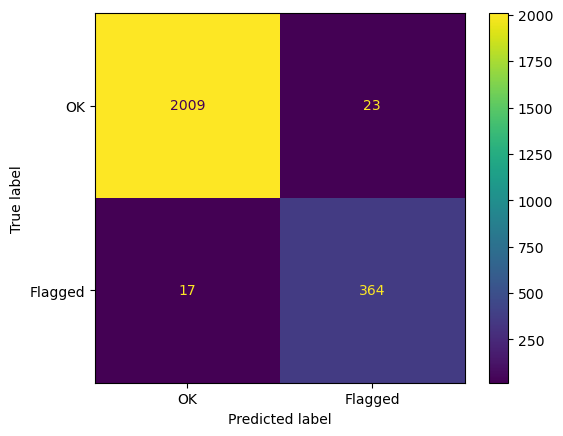

In [16]:
xgb_c = XGBClassifier(random_state=42,objective='binary:logistic',use_label_encoder=False,eval_metric='auc')
xgb_c.fit(x_tr, y_tr.astype(int))
preds = xgb_c.predict(x)

print(classification_report(y, preds))
cm = confusion_matrix(y, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=['OK','Flagged'])
disp.plot()

plt.show()

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2032
         1.0       0.89      0.93      0.91       381

    accuracy                           0.97      2413
   macro avg       0.94      0.95      0.94      2413
weighted avg       0.97      0.97      0.97      2413



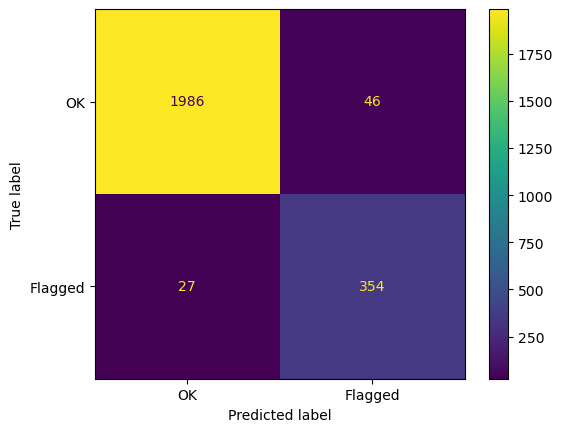

In [17]:
show_metrics(deep_model,x,y)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      2032
         1.0       0.92      0.90      0.91       381

    accuracy                           0.97      2413
   macro avg       0.95      0.94      0.95      2413
weighted avg       0.97      0.97      0.97      2413



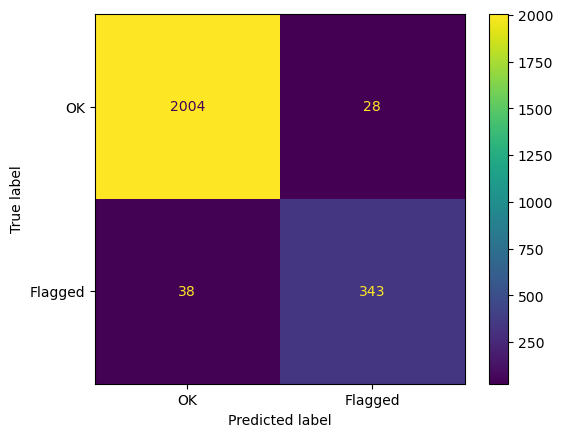

In [18]:
show_metrics(shallow_model,x,y)

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2032
         1.0       0.86      0.92      0.89       381

    accuracy                           0.96      2413
   macro avg       0.92      0.95      0.93      2413
weighted avg       0.97      0.96      0.96      2413



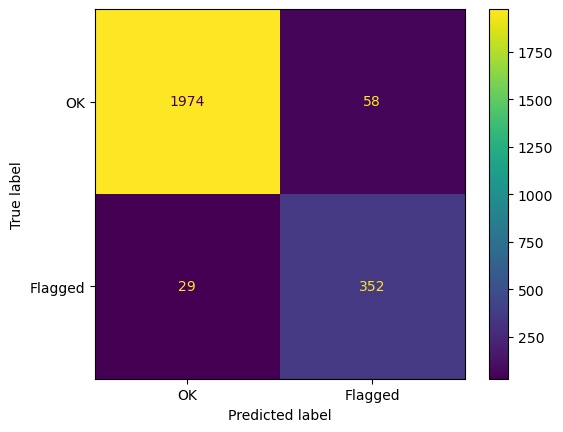

In [19]:
show_metrics(deep_weighted_model,x,y)

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      2032
         1.0       0.83      0.95      0.89       381

    accuracy                           0.96      2413
   macro avg       0.91      0.96      0.93      2413
weighted avg       0.97      0.96      0.96      2413



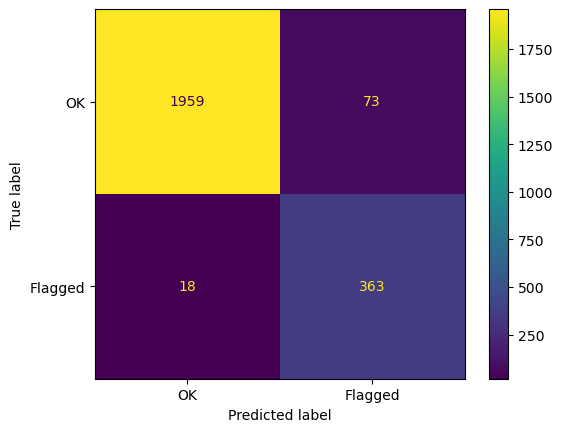

In [20]:
show_metrics(shallow_weighted_model,x,y)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2032
         1.0       0.90      0.94      0.92       381

    accuracy                           0.97      2413
   macro avg       0.94      0.96      0.95      2413
weighted avg       0.97      0.97      0.97      2413



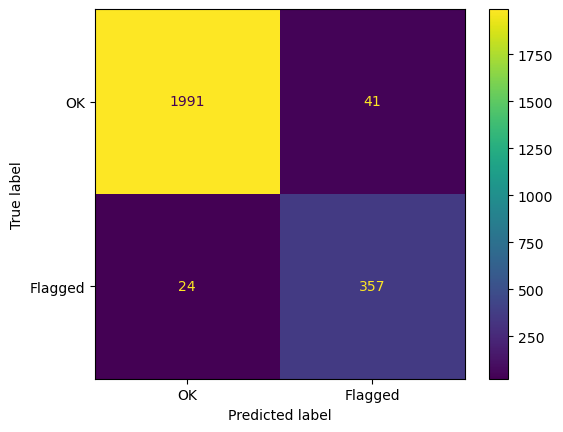

In [21]:
show_metrics(no_dropout_model,x,y)